In [1]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys

import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from CNN import ConvNet1
from training_functions import *

In [2]:
batch_size = 128
num_epochs = 25

In [3]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [4]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12554, 128, 45)
(2696, 128, 45)
(2689, 128, 45)
(12554,)
(2696,)
(2689,)


In [5]:
np.unique(y_val)

array(['2_walking', 'clutter/noise', 'running', 'sphere_swing', 'vehicle',
       'walking'], dtype='<U13')

In [5]:
# Creating the data loaders
train_loader, val_loader, test_loader = createDataloaders(x_train, y_train, x_val, y_val, x_test, y_test, batch_size)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 30 * 9, 128)

        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)

        self.dropout3 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 30 * 9)
        #x = self.dropout1(x)

        x = F.relu(self.fc1(x))

        #x = self.dropout2(x)
        x = F.relu(self.fc2(x))

        #x = self.dropout3(x)
        x = self.fc3(x)
        
        return x


In [34]:
# Global Averaging model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(0.25)
        #self.fc1 = nn.Linear(32 * 30 * 9, 128)
        self.fc1 = nn.Linear(32 * 1 * 1, 6)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)

        self.dropout3 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = self.avgpool(x)

        x = x.view(-1, 32 * 1 * 1)

        x = self.fc1(x)

        #x = x.view(-1, 32 * 30 * 9)
        #x = self.dropout1(x)

        #x = F.relu(self.fc1(x))

        #x = self.dropout2(x)
        #x = F.relu(self.fc2(x))

        #x = self.dropout3(x)
        #x = self.fc3(x)
        
        return x

In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 32 * 11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 32 * 32 * 11)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second block
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # Third Block
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # Fourth Block
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc1 = nn.Linear(32 * 32 * 11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))

        residual = x

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x += residual # Adding residual connection

        x = F.relu(self.conv4(x))

        x = x.view(-1, 32 * 32 * 11)

        #x = self.dropout(x)
        x = F.relu(self.fc1(x))

        #x = self.dropout(x)
        x = F.relu(self.fc2(x))

        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [24]:
# Batch Norm Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(0.5)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # Dense layer 1
        self.fc1 = nn.Linear(64 * 1 * 1, 6)
        #self.bn3 = nn.BatchNorm1d(128)

        # Dense layer 2
        # self.fc2 = nn.Linear(128, 64)
        # self.bn4 = nn.BatchNorm1d(64)
        # self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        print(x.shape)
        # Global average pool
        x = self.avgpool(x)

        x = x.view(-1, 64 * 1 * 1)

        x = self.avgpool(x)

        x = self.fc1(x)


        # x = self.dropout(x)
        # x = F.relu(self.bn3(self.fc1(x)))
        # # x = self.dropout(x)
        # x = F.relu(self.bn4(self.fc2(x)))
        # # x = self.dropout(x)
        # x = self.fc3(x)
        return x



In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 16 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 16 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [24]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20,20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(20 * 1 *8, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [55]:
# Kaggle model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            #nn.Dropout(p=0.5),
            nn.Linear(64*32*11, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            nn.Linear(64, 6)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [35]:
# Select a model from ../Models

model_1  = Net()
device = get_device()
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [26]:
data = iter(train_loader)
images, _ = next(data)

In [17]:
images = images.to(device, dtype=torch.float)
x = model_1.conv_block(images)
x.shape

torch.Size([128, 128, 32, 11])

In [27]:
images = images.to(device, dtype=torch.float)
"""
x = model_1.pool1(F.relu(model_1.conv1(images)))

residual = x

x = F.relu(model_1.conv2(x))
x = F.relu(model_1.conv3(x))

x += residual # Adding residual connection

x = (F.relu(model_1.conv4(x)))

"""
images = images.to(device, dtype=torch.float)
x = model_1.pool1(F.relu(model_1.conv1(images)))
print(x.shape)
x = model_1.pool2(F.relu(model_1.conv2(x)))
x = model_1.avgpool(x)
print(x.shape)
x = F.relu(model_1.conv3(x))
x = model_1.pool(F.relu(model_1.conv4(x)))

x.shape

ModuleAttributeError: 'Net' object has no attribute 'pool1'

In [36]:
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_on_device.parameters()) # momentum=0.9

In [20]:
class_weights

tensor([0.9848, 1.0108, 1.2858, 1.4546, 0.6800, 0.9439], device='cuda:0')

In [22]:
model_on_device

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=6, bias=True)
)

In [37]:
train_model(80, train_loader, val_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/80 	 Training Loss: 1.5513, Accuracy: 17.09, Testing Loss: 1.7907, Accuracy: 16.33
Validation loss decreased (inf --> 1.790652).  Saving model ...
Epoch: 2/80 	 Training Loss: 1.5463, Accuracy: 22.19, Testing Loss: 1.7847, Accuracy: 30.98
Validation loss decreased (1.790652 --> 1.784739).  Saving model ...
Epoch: 3/80 	 Training Loss: 1.5379, Accuracy: 26.58, Testing Loss: 1.7700, Accuracy: 25.36
Validation loss decreased (1.784739 --> 1.770022).  Saving model ...
Epoch: 4/80 	 Training Loss: 1.5294, Accuracy: 30.12, Testing Loss: 1.7812, Accuracy: 20.23
EarlyStopping counter: 1 out of 20
Epoch: 5/80 	 Training Loss: 1.5110, Accuracy: 31.23, Testing Loss: 1.7321, Accuracy: 26.96
Validation loss decreased (1.770022 --> 1.732073).  Saving model ...
Epoch: 6/80 	 Training Loss: 1.4872, Accuracy: 31.44, Testing Loss: 1.7174, Accuracy: 32.13
Validation loss decreased (1.732073 --> 1.717386).  Saving model ...
Epoch: 7/80 	 Training Loss: 1.4603, Accuracy: 34.49, Testing Loss: 1.704

In [38]:
model_1.load_state_dict(torch.load("checkpoint.pt"))
model_on_device = model_1.to(device)

In [39]:
test_loss, test_accuracy , _, _, _ = evaluate_model(test_loader, device, model_on_device, criterion)
test_accuracy

49.295252225519285

In [21]:
torch.save(model_on_device, "model_cnn.pth")

In [14]:
dummy_input = torch.randn(128, 1, 128, 44, device='cuda')
torch.onnx.export(model_on_device, dummy_input, "model_cnn.onnx")

In [13]:
model_on_device = torch.load("model_cnn.pth")

In [42]:
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])
# Create the datasets
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

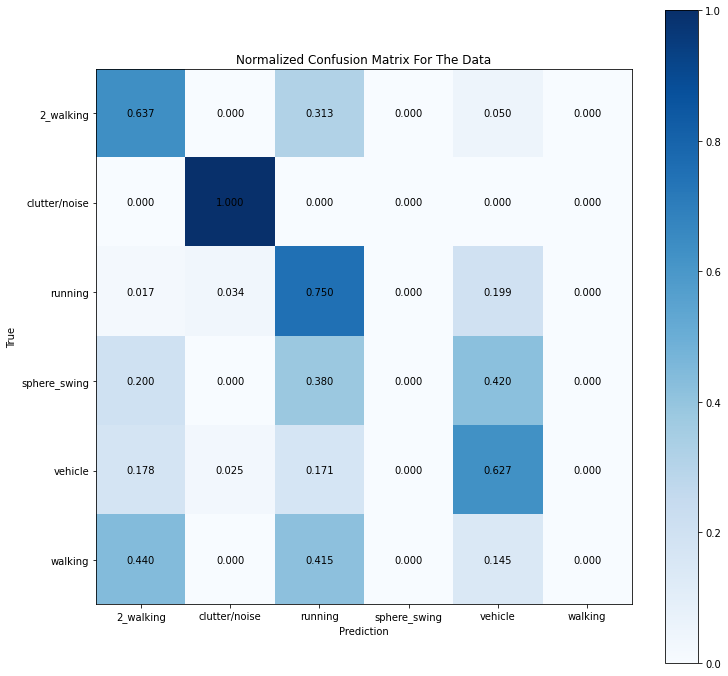

52.309404563160825

In [64]:
# Evaluate model performance on test data
#from training_functions import *
_, accuracy,errors,  y_pred_errors, y_true_errors = evaluate_model(test_loader, device, model_on_device, criterion, train_dataset, 'The')
accuracy

In [56]:
np.where(errors==True)

(array([   2,    3,   19,  261,  293,  313,  382,  406,  420,  422,  423,
         424,  429,  430,  431,  432,  433,  434,  435,  436,  437,  438,
         440,  441,  442,  443,  444,  445,  446,  447,  448,  449,  450,
         451,  452,  453,  454,  455,  456,  458,  459,  460,  461,  462,
         463,  465,  466,  467,  473,  474,  475,  476,  477,  478,  479,
         481,  482,  483,  484,  485,  486,  487,  488,  489,  490,  491,
         492,  493,  494,  495,  496,  497,  499,  501,  503,  504,  505,
         507,  508,  509,  510,  512,  513,  517,  518,  519,  521,  522,
         523,  524,  525,  526,  528,  529,  530,  531,  532,  533,  534,
         535,  536,  537,  538,  539,  540,  541,  543,  544,  545,  546,
         547,  548,  550,  551,  552,  555,  556,  557,  558,  560,  562,
         563,  564,  565,  566,  567,  568,  569,  570,  571,  572,  573,
         574,  576,  577,  578,  579,  580,  581,  582,  584,  585,  588,
         589,  590,  591,  592,  593, 

In [18]:
x_test_errors = x_test[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, test_dataset)

NameError: name 'display_errors' is not defined

In [53]:
np.where(errors==True)

(array([  573,  1395,  3186,  3599,  4011,  4131,  4338,  5027,  5469,
         5549,  6199,  6370,  6462,  7149,  8455,  9923, 10004, 10387,
        10814, 10860], dtype=int64),)

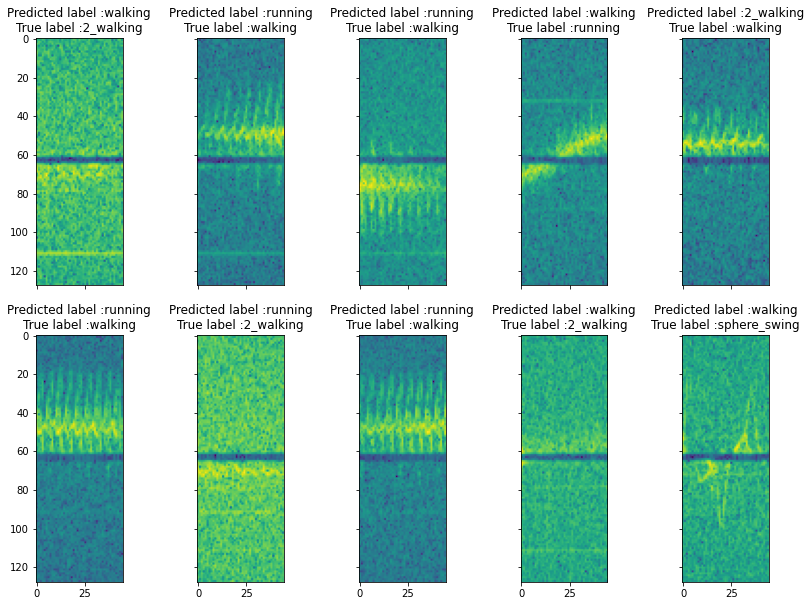

In [24]:
x_test_errors = x_test[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, test_dataset)

In [49]:
test_dataset

In [99]:
import random
randomlist = random.sample(range(10, 30), 5)
def display_errors(img_errors, pred_errors, obs_errors, dataset):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    errors_index = random.sample(range(0, len(img_errors)), nrows*ncols)
    classes = dataset.enc.classes_.tolist()
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(14,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((128,45)), cmap='turbo')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format( classes[int(pred_errors[error])], classes[int(obs_errors[error])]  ))
            n += 1

In [45]:
classes = va_dataset.enc.classes_.tolist()
classes

['2_walking', 'clutter/noise', 'running', 'sphere_swing', 'vehicle', 'walking']

In [59]:
# Adapted from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6


In [26]:
def evaluate_model(loader, device, model_on_device, criterion, *args):

    """Evaluate Performance on test set"""
    model_on_device.eval() # Turn off gradient computations
    num_batches = len(loader)
    correct = 0
    total = 0
    running_loss = 0
    y_tot=torch.empty(0)
    y_pred_tot=torch.empty(0)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model_on_device(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()


            labels=labels.cpu()
            predicted=predicted.cpu()

            y_tot = torch.cat((y_tot, labels), 0)
            y_pred_tot = torch.cat((y_pred_tot, predicted), 0)

    accuracy = 100 * correct / total       
    errors = (y_pred_tot - y_tot  != 0)
    y_pred_errors = y_pred_tot[errors]
    y_true_errors = y_tot[errors]

    # Plotting the Confusion Matrix
    assert len(args)==2 or len(args)==0, 'Please insert both dataset and dataset name'
    if args:
        cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy())
        np.set_printoptions(precision=4)

        # Coloured confusion matrix
        plt.figure(figsize = (12,12))
        cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy(), normalize="true")
        plt.imshow(cm, cmap=plt.cm.Blues)

        for (i, j), z in np.ndenumerate(cm):
            plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
        
        plt.xticks(range(6))
        plt.yticks(range(6))
        plt.xlabel("Prediction")
        plt.ylabel("True")

        # We can retrieve the categories used by the LabelEncoder
        classes = args[0].enc.classes_.tolist()
        plt.gca().set_xticklabels(classes)
        plt.gca().set_yticklabels(classes)

        plt.title("Normalized Confusion Matrix For "+ args[1] + " Data")
        plt.colorbar()
        plt.show()
    return running_loss / num_batches, accuracy, errors, y_pred_errors, y_true_errors 

In [15]:
model_on_device.eval()
Y_pred = model_on_device.predict(x_val)

ModuleAttributeError: 'Net' object has no attribute 'predict'

In [15]:

Confusion_Matrix(model_on_device, train_loader, train_dataset, 'train')

NameError: name 'Confusion_Matrix' is not defined

In [28]:
# Save the model
torch.save(model_on_device, "model.pth")

## Training using the cross validation approach

### Adapted from https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

In [70]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from pytorchtools import EarlyStopping
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [71]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data_cv.npz"
processed_data = np.load(compressed_file_path) # Unzipping
x_train_cv = processed_data["x_train"]
y_train_cv = processed_data["y_train"]

x_test_cv = processed_data["x_test"]
y_test_cv = processed_data["y_test"]

In [72]:
# Configuration options
device = get_device() 
k_folds = 10
num_epochs = 50


class_weights = get_class_weights(y_train_cv, device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)


# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Prepare MNIST dataset by concatenating Train/Test part; we split later.
""""
dataset_train_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
dataset_test_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)
dataset = ConcatDataset([dataset_train_part, dataset_test_part])
"""
transform = transforms.Compose(
[
transforms.ToTensor()
])
# Create the datasets
dataset_train_part = HAVSDataset(x_train_cv, y_train_cv, transform=transform)
dataset_test_part = HAVSDataset(x_test_cv, y_test_cv, transform=transform)
dataset = dataset_train_part

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=False)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, y_train_cv)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=10, sampler=test_subsampler)

    # Init the neural network
    network = Net()
    network_on_device = network.to(device) # Move model to the current device
    network_on_device.apply(reset_weights)


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network_on_device.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
        
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
  
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = network_on_device(inputs)
            
            # Compute loss
            loss = loss_function(outputs, targets)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                        (i + 1, current_loss / 500))
                current_loss = 0.0

        # Check early stopping
        test_loss, _, _, _, _ = evaluate_model(testloader, device, network_on_device, loss_function)
        early_stopping(test_loss, network_on_device)
        if early_stopping.early_stop:
            print("Early stopping")
            break           
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
            # Generate outputs
            outputs = network_on_device(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

r mini-batch   500: 0.002
Loss after mini-batch  1000: 0.002
EarlyStopping counter: 9 out of 20
Starting epoch 15
Loss after mini-batch   500: 0.013
Loss after mini-batch  1000: 0.010
EarlyStopping counter: 10 out of 20
Starting epoch 16
Loss after mini-batch   500: 0.006
Loss after mini-batch  1000: 0.001
EarlyStopping counter: 11 out of 20
Starting epoch 17
Loss after mini-batch   500: 0.001
Loss after mini-batch  1000: 0.000
EarlyStopping counter: 12 out of 20
Starting epoch 18
Loss after mini-batch   500: 0.003
Loss after mini-batch  1000: 0.018
EarlyStopping counter: 13 out of 20
Starting epoch 19
Loss after mini-batch   500: 0.016
Loss after mini-batch  1000: 0.015
EarlyStopping counter: 14 out of 20
Starting epoch 20
Loss after mini-batch   500: 0.000
Loss after mini-batch  1000: 0.000
EarlyStopping counter: 15 out of 20
Starting epoch 21
Loss after mini-batch   500: 0.000
Loss after mini-batch  1000: 0.000
EarlyStopping counter: 16 out of 20
Starting epoch 22
Loss after mini-ba

In [84]:
test_loader = DataLoader(dataset=dataset_test_part, batch_size=batch_size, shuffle=False)

In [85]:
model = Net()
model.load_state_dict(torch.load('model-fold-3.pth'))
model_0_on_device = model.to(device)

In [81]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=dataset_train_part, batch_size=batch_size, shuffle=True)

In [82]:
model = Net()
model_0_on_device = model.to(device)
# Training the model on the whole dataset
train_model(50, train_loader, test_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/50 	 Training Loss: 0.2549, Accuracy: 92.44, Testing Loss: 0.5353, Accuracy: 76.02
Validation loss decreased (inf --> 0.535278).  Saving model ...
Epoch: 2/50 	 Training Loss: 0.2223, Accuracy: 92.78, Testing Loss: 1.2239, Accuracy: 72.51
EarlyStopping counter: 1 out of 20
Epoch: 3/50 	 Training Loss: 0.2032, Accuracy: 93.23, Testing Loss: 2.9368, Accuracy: 54.31
EarlyStopping counter: 2 out of 20
Epoch: 4/50 	 Training Loss: 0.2052, Accuracy: 93.66, Testing Loss: 8.2236, Accuracy: 22.93
EarlyStopping counter: 3 out of 20
Epoch: 5/50 	 Training Loss: 0.2516, Accuracy: 93.72, Testing Loss: 0.5252, Accuracy: 79.02
Validation loss decreased (0.535278 --> 0.525191).  Saving model ...
Epoch: 6/50 	 Training Loss: 0.1915, Accuracy: 93.84, Testing Loss: 5.7389, Accuracy: 43.52
EarlyStopping counter: 1 out of 20
Epoch: 7/50 	 Training Loss: 0.1867, Accuracy: 94.07, Testing Loss: 0.3295, Accuracy: 85.42
Validation loss decreased (0.525191 --> 0.329469).  Saving model ...
Epoch: 8/50 	 

In [88]:
model = Net()
model.load_state_dict(torch.load("checkpoint.pt"))
model_on_device = model.to(device)
evaluate_model(test_loader, device, model_on_device, loss_function)

(0.3294752241189902,
 85.42014468558709,
 tensor([False, False, False,  ..., False, False, False]),
 tensor([2., 2., 4., 5., 1., 5., 5., 1., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
         5., 5., 5., 5., 5., 5., 3., 5., 3., 3., 3., 2., 5., 5., 5., 5., 5., 3.,
         5., 3., 3., 3., 2., 5., 5., 5., 5., 5., 5., 3., 0., 5., 5., 5., 0., 2.,
         0., 0., 2., 2., 2., 2., 0., 2., 2., 2., 0., 4., 4., 0., 0., 0., 0., 0.,
         

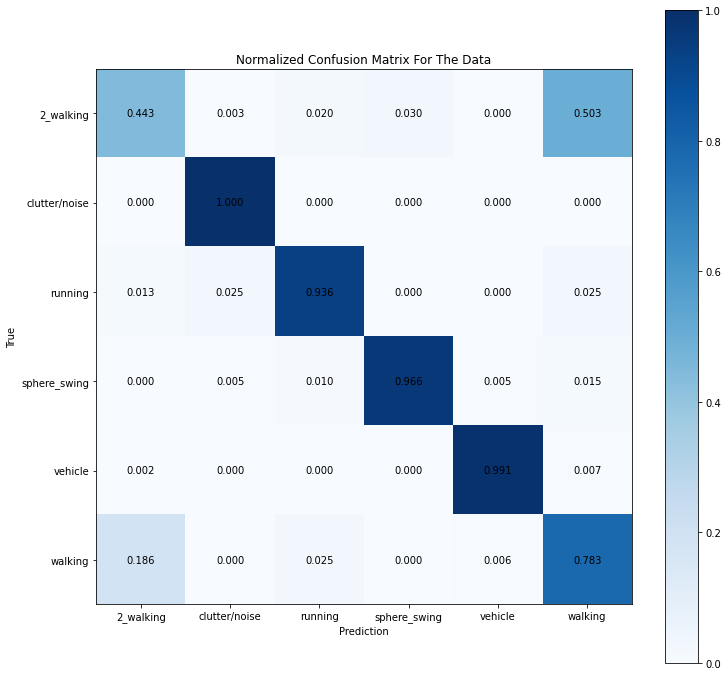

85.42014468558709

In [89]:
# Evaluate model performance on test data
#from training_functions import *
_, accuracy,errors,  y_pred_errors, y_true_errors = evaluate_model(test_loader, device, model_on_device, loss_function, train_dataset, 'The')
accuracy

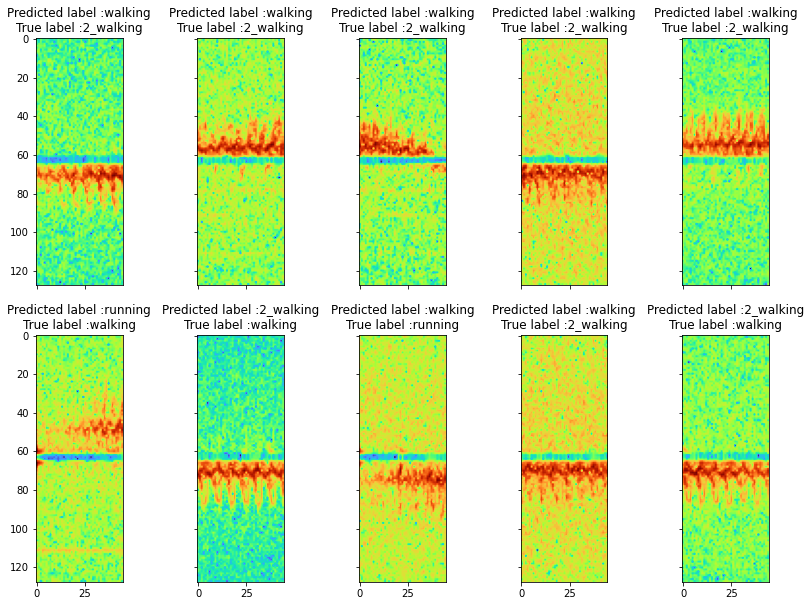

In [104]:
x_test_errors = x_test[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, test_dataset)